#**Dataset Description based on EDA**

The Food Reviews dataset 


1.   Number of reviews: 568,454
2.   Number of users: 256,059
3.  Number of products: 74,258
4.  Timespan: Oct 1999 - Oct 2012
5.  Number of Attributes/Columns in data: 10

Attribute Information

1. **Id** - Row Id

2. **ProductId** - Unique identifier for the product

3. **UserId** - Unique identifier for the user

4. **ProfileName** - Profile name of the user

5. **HelpfulnessNumerator** - Number of users who found the review helpful

6. **HelpfulnessDenominator** - Number of users who indicated whether they found the review helpful or not

7. **Score** - Rating between 1 and 5

8. **Time** - Timestamp for the review

9. **Summary** - Brief summary of the review

10. **Text** - Text of the review

**How to determine if a review is positive or negative?**

We could use the Score/Rating. A rating of 4 or 5 could be cosnidered a positive review. A review of 1 or 2 could be considered negative. A review of 3 is nuetral and ignored. This is an approximate and proxy way of determining the polarity (positivity/negativity) of a review.

**Loading the data**

The dataset is available in two forms

1.   .csv file
2.   SQLite Database

In order to load the data, We have used the SQLITE dataset as it easier to query the data and visualise the data efficiently.

Here as we only want to get the global sentiment of the recommendations (positive or negative), we will purposefully ignore all Scores equal to 3. 

If the score id above 3, then the recommendation wil be set to "positive". Otherwise, it will be set to "negative".

#**Loading the file**

In [1]:
!gdown --id 1WCmb5JyfGpL3YEJFTxCTzdv12ODmjF1O

Downloading...
From: https://drive.google.com/uc?id=1WCmb5JyfGpL3YEJFTxCTzdv12ODmjF1O
To: /content/Reviews.csv
100% 301M/301M [00:02<00:00, 112MB/s] 


#**Imports**

In [20]:
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")
import sqlite3
import pandas as pd
import numpy as np
import nltk
import string
import matplotlib.pyplot as plt
import matplotlib.pyplot as pyplt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.metrics import roc_curve, auc
from nltk.stem.porter import PorterStemmer
import re
import string
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.stem.wordnet import WordNetLemmatizer
import pickle
from tqdm import tqdm
import os
from bs4 import BeautifulSoup

#**Creating a SQLite Database**

In [3]:
from pathlib import Path
Path('my_data.db').touch()

In [4]:
import sqlite3
conn = sqlite3.connect('my_data.db')
c = conn.cursor()

In [5]:
import pandas as pd
# load the data into a Pandas DataFrame
Reviews = pd.read_csv('Reviews.csv')
# write the data to a sqlite table
Reviews.to_sql('Reviews', conn, if_exists='append', index = False)

In [6]:
# using the SQLite Table to read data.
con = sqlite3.connect('my_data.db') 
#filtering only positive and negative reviews i.e. 
# not taking into consideration those reviews with Score=3
filtered_data = pd.read_sql_query(""" SELECT * FROM Reviews WHERE Score != 3 """, con) 


# Give reviews with Score>3 a positive rating, and reviews with a score<3 a negative rating.
def partition(x):
    if x < 3:
        return 0
    return 1

#changing reviews with score less than 3 to be positive and vice-versa
actualScore = filtered_data['Score']
positiveNegative = actualScore.map(partition) 
filtered_data['Score'] = positiveNegative
print("Number of data points in our data", filtered_data.shape)
filtered_data.head(3)

Number of data points in our data (525814, 10)


,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,1,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,0,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,1,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...


# **Data Cleaning**

It is observed (as shown in the table below) that the reviews data had many duplicate entries. Hence it was necessary to remove duplicates in order to get unbiased results for the analysis of the data. Following is an example

In [7]:
display= pd.read_sql_query("""
SELECT *
FROM Reviews
WHERE Score != 3 AND UserId="AR5J8UI46CURR"
ORDER BY ProductID
""", con)
display.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,78445,B000HDL1RQ,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
1,138317,B000HDOPYC,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
2,138277,B000HDOPYM,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
3,73791,B000HDOPZG,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
4,155049,B000PAQ75C,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...


As can be seen above the same user has multiple reviews of the with the same values for HelpfulnessNumerator, HelpfulnessDenominator, Score, Time, Summary and Text and on doing analysis it was found that

ProductId=B000HDOPZG was Loacker Quadratini Vanilla Wafer Cookies, 8.82-Ounce Packages (Pack of 8)

ProductId=B000HDL1RQ was Loacker Quadratini Lemon Wafer Cookies, 8.82-Ounce Packages (Pack of 8) and so on

It was inferred after analysis that reviews with same parameters other than ProductId belonged to the same product just having different flavour or quantity. Hence in order to reduce redundancy it was decided to eliminate the rows having same parameters.

The method used for the same was that we first sort the data according to ProductId and then just keep the first similar product review and delete the others. for example in the above just the review for ProductId=B000HDL1RQ remains. This method ensures that there is only one representative for each product and deduplication without sorting would lead to possibility of different representatives still existing for the same product.

In [8]:
#Sorting data according to ProductId in ascending order
sorted_data=filtered_data.sort_values('ProductId', axis=0, ascending=True, inplace=False, kind='quicksort', na_position='last')
sorted_data.head(5)

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
138706,150524,0006641040,ACITT7DI6IDDL,shari zychinski,0,0,1,939340800,EVERY book is educational,this witty little book makes my son laugh at l...
138688,150506,0006641040,A2IW4PEEKO2R0U,Tracy,1,1,1,1194739200,"Love the book, miss the hard cover version","I grew up reading these Sendak books, and watc..."
138689,150507,0006641040,A1S4A3IQ2MU7V4,"sally sue ""sally sue""",1,1,1,1191456000,chicken soup with rice months,This is a fun way for children to learn their ...
138690,150508,0006641040,AZGXZ2UUK6X,"Catherine Hallberg ""(Kate)""",1,1,1,1076025600,a good swingy rhythm for reading aloud,This is a great little book to read aloud- it ...
138691,150509,0006641040,A3CMRKGE0P909G,Teresa,3,4,1,1018396800,A great way to learn the months,This is a book of poetry about the months of t...


In [9]:
#Deduplication of entries
final=sorted_data.drop_duplicates(subset={"UserId","ProfileName","Time","Text"}, keep='first', inplace=False)
final.shape

(364173, 10)

It was also seen that in two rows given below the value of HelpfulnessNumerator is greater than HelpfulnessDenominator which is not practically possible hence these two rows too are removed from calcualtions

In [11]:
display= pd.read_sql_query("""
SELECT *
FROM Reviews
WHERE Score != 3 AND Id=44737 OR Id=64422
ORDER BY ProductID
""", con)

display.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,64422,B000MIDROQ,A161DK06JJMCYF,"J. E. Stephens ""Jeanne""",3,1,5,1224892800,Bought This for My Son at College,My son loves spaghetti so I didn't hesitate or...
1,44737,B001EQ55RW,A2V0I904FH7ABY,Ram,3,2,4,1212883200,Pure cocoa taste with crunchy almonds inside,It was almost a 'love at first bite' - the per...


In [12]:
final=final[final.HelpfulnessNumerator<=final.HelpfulnessDenominator]

In [13]:
#Checking to see how much % of data still remains
(final['Id'].size*1.0)/(filtered_data['Id'].size*1.0)*100

69.25852107399194

In [14]:
#Before starting the next phase of preprocessing lets see the number of entries left
print("Number of entries left")
print(final.shape)

#How many positive and negative reviews are present in our dataset?
print("Number of positive and negative reviews in the dataset")
final['Score'].value_counts()

Number of entries left
(364171, 10)
Number of positive and negative reviews in the dataset


1    307061
0     57110
Name: Score, dtype: int64

#**Text Preprocessing: Stemming, stop-word removal and Lemmatization**

Now that we have finished deduplication our data requires some preprocessing before we go on further with analysis and making the prediction model.

Hence in the Preprocessing phase we do the following in the order below:-
1. Begin by removing the html tags

2. Remove any punctuations or limited set of special characters like , or . or # etc.

3. Check if the word is made up of english letters and is not alpha-numeric

4. Check to see if the length of the word is greater than 2 (as it was researched that there is no adjective in 2-letters)

5. Convert the word to lowercase

6. Remove Stopwords

7. Finally Snowball Stemming the word (it was observed to be better than Porter Stemming)

After which we collect the words used to describe positive and negative reviews

In [16]:
nltk.download('stopwords')
stop=set(stopwords.words('english'))#set of stop words
snow=nltk.stem.SnowballStemmer('english') #set of snow ball stemmers in english

def cleanhtml(sentence): #function to clean html tags in a sentence
    cleannr=re.compile('<.*?>')
    cleantext=re.sub(cleannr,'',sentence)
    return cleantext

def cleanpunc(sentence) : #function to clean punctuation in the sentence
    cleaned=re.sub(r'[? | ! | \' |" | #]',r'',sentence)
    cleaned=re.sub(r'[. | , | ) | ( | \ | / ]' ,r' ',sentence)
    return cleaned

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [17]:
def decontracted(phrase):
    # specific
    phrase = re.sub(r"won't", "will not", phrase)
    phrase = re.sub(r"can\'t", "can not", phrase)

    # general
    phrase = re.sub(r"n\'t", " not", phrase)
    phrase = re.sub(r"\'re", " are", phrase)
    phrase = re.sub(r"\'s", " is", phrase)
    phrase = re.sub(r"\'d", " would", phrase)
    phrase = re.sub(r"\'ll", " will", phrase)
    phrase = re.sub(r"\'t", " not", phrase)
    phrase = re.sub(r"\'ve", " have", phrase)
    phrase = re.sub(r"\'m", " am", phrase)
    return phrase

In [23]:
stopwords= set(['br', 'the', 'i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've",\
            "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', \
            'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their',\
            'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', \
            'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', \
            'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', \
            'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after',\
            'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further',\
            'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more',\
            'most', 'other', 'some', 'such', 'only', 'own', 'same', 'so', 'than', 'too', 'very', \
            's', 't', 'can', 'will', 'just', 'don', "don't", 'should', "should've", 'now', 'd', 'll', 'm', 'o', 're', \
            've', 'y', 'ain', 'aren', "aren't", 'couldn', "couldn't", 'didn', "didn't", 'doesn', "doesn't", 'hadn',\
            "hadn't", 'hasn', "hasn't", 'haven', "haven't", 'isn', "isn't", 'ma', 'mightn', "mightn't", 'mustn',\
            "mustn't", 'needn', "needn't", 'shan', "shan't", 'shouldn', "shouldn't", 'wasn', "wasn't", 'weren', "weren't", \
            'won', "won't", 'wouldn', "wouldn't"])

In [27]:
#code for step by step implementing text preprocess
i=0
str1=' '
preprocessed_reviews=[]
all_positive_words=[] #store words from +ve reviews here
all_negative_words=[] # store words from -ve reviews here
s=''

for sentence in tqdm(final['Text'].values):
    filtered_sentence=[]
    sentence=cleanhtml(sentence)
    sentence = re.sub(r"http\S+", "", sentence)
    sentence = BeautifulSoup(sentence, 'lxml').get_text()
    sentence = decontracted(sentence)
    sentence = re.sub("\S*\d\S*", "", sentence).strip()
    sentence = re.sub('[^A-Za-z]+', ' ', sentence)
    for w in sentence.split():
        for cleaned_words in cleanpunc(w).split():
            if((cleaned_words.isalpha()) & (len(cleaned_words) > 2)):
                if (cleaned_words.lower() not in stopwords):
                    s=(snow.stem(cleaned_words.lower())).encode('utf8')
                    filtered_sentence.append(s)
                    if (final['Score'].values[i]) == 1 :
                      all_positive_words.append(s) #list all the positive words
                    if (final['Score'].values[i]) == 0 :
                       all_negative_words.append(s) #list all the negative words
                else:
                    continue
            else:
                continue
    str1=b" ".join(filtered_sentence) #final string of the filtered sentence
    preprocessed_reviews.append(str1.strip())
    i+=1

100%|██████████| 364171/364171 [10:57<00:00, 554.14it/s]


In [28]:
final['preprocessed_reviews']=preprocessed_reviews
final['preprocessed_reviews']=final['preprocessed_reviews'].str.decode("utf-8")
final.to_csv('preprocessed_reviews.csv',index=False)

# **Building the Model**

In [30]:
#loading the preprocessed_data
data=pd.read_csv('preprocessed_reviews.csv',nrows=25000)

In [31]:
data['Score'].value_counts()

1    21204
0     3796
Name: Score, dtype: int64

In [33]:
X=data['preprocessed_reviews'].values
Y=data['Score'].values

In [34]:
#Splitting of data
from sklearn.model_selection import train_test_split
X_train,X_test,Y_train,Y_test=train_test_split(X,Y,test_size=0.3,shuffle=False)

Featurization using Bag of Words Approach

In [35]:
BOW=CountVectorizer(ngram_range=(2,3),min_df=10)
X_train_Bow=BOW.fit_transform(X_train)
X_test_Bow=BOW.transform(X_test)

Creating a pickle file for the vectorizer

In [36]:
pickle.dump(BOW, open('vectorizer_new.pkl','wb'))

In [37]:
#compute best alpha using hyperparameter tuning 
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import KFold
from sklearn.model_selection import GridSearchCV

cv=KFold(n_splits=5) #defining the K-fold cross validation
alpha_values = [0.00001,0.0001,0.001,0.01,0.1,1,10,100,1000,10000,100000]#alpha from 10^-5 to 10^5
model=MultinomialNB()
parameters = {'alpha':alpha_values}
clf = GridSearchCV(model,parameters, cv=cv, scoring='roc_auc',return_train_score=True,verbose=1)
clf.fit(X_train_Bow, Y_train)

Fitting 5 folds for each of 11 candidates, totalling 55 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  55 out of  55 | elapsed:    1.0s finished


GridSearchCV(cv=KFold(n_splits=5, random_state=None, shuffle=False),
             error_score=nan,
             estimator=MultinomialNB(alpha=1.0, class_prior=None,
                                     fit_prior=True),
             iid='deprecated', n_jobs=None,
             param_grid={'alpha': [1e-05, 0.0001, 0.001, 0.01, 0.1, 1, 10, 100,
                                   1000, 10000, 100000]},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
             scoring='roc_auc', verbose=1)

In [38]:
#defining train and cross_validation
train_auc= clf.cv_results_['mean_train_score']
train_auc_std= clf.cv_results_['std_train_score']
cv_auc = clf.cv_results_['mean_test_score'] 
cv_auc_std= clf.cv_results_['std_test_score']
best_alpha= clf.best_params_['alpha']

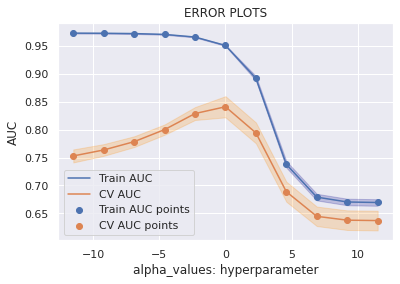

In [39]:
import math
sns.set()
alpha_values=[math.log(x) for x in alpha_values]
plt.plot(alpha_values, train_auc, label='Train AUC')
plt.gca().fill_between(alpha_values,train_auc - train_auc_std,train_auc + train_auc_std,alpha=0.2,color='darkblue')
plt.plot(alpha_values, cv_auc, label='CV AUC')
plt.gca().fill_between(alpha_values,cv_auc - cv_auc_std,cv_auc + cv_auc_std,alpha=0.2,color='darkorange')
plt.scatter(alpha_values, train_auc, label='Train AUC points')
plt.scatter(alpha_values, cv_auc, label='CV AUC points')
plt.legend()
plt.xlabel("alpha_values: hyperparameter")
plt.ylabel("AUC")
plt.title("ERROR PLOTS")
plt.show()

In [41]:
print("Best Cross-Validation Score: {:.3f}".format(clf.best_score_))
print('The best alpha from GridSearch :',best_alpha)

Best Cross-Validation Score: 0.841
The best alpha from GridSearch : 1


In [42]:
#training the model with best alpha
model=MultinomialNB(alpha=1)
model.fit(X_train_Bow, Y_train)

MultinomialNB(alpha=1, class_prior=None, fit_prior=True)

# **Performance Metrics**

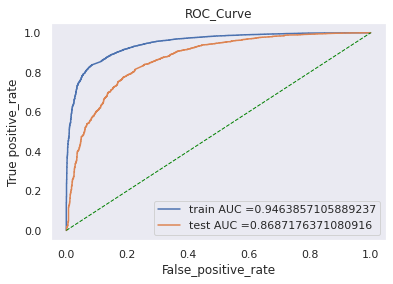

The AUC score of test data is : 0.8687176371080916


In [45]:
train_fpr, train_tpr, thresholds = roc_curve(Y_train, model.predict_proba(X_train_Bow)[:,1])
test_fpr, test_tpr, thresholds = roc_curve(Y_test, model.predict_proba(X_test_Bow)[:,1])

sns.set()
plt.plot(train_fpr, train_tpr, label="train AUC ="+str(auc(train_fpr, train_tpr)))
plt.plot(test_fpr, test_tpr, label="test AUC ="+str(auc(test_fpr, test_tpr)))
plt.plot([0, 1], [0, 1], color='green', lw=1, linestyle='--')
plt.legend()
plt.xlabel("False_positive_rate")
plt.ylabel("True positive_rate")    
plt.title("ROC_Curve")
plt.grid()
plt.show()
print('The AUC score of test data is :',auc(test_fpr, test_tpr))

In [47]:
predict=model.predict(X_test_Bow)

              precision    recall  f1-score   support

           0       0.61      0.51      0.56      1101
           1       0.92      0.94      0.93      6399

    accuracy                           0.88      7500
   macro avg       0.77      0.73      0.75      7500
weighted avg       0.87      0.88      0.88      7500



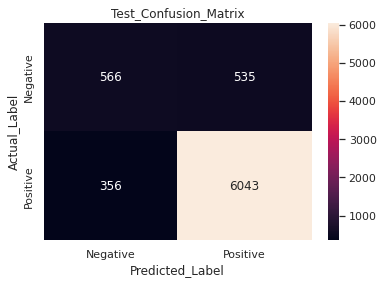

In [49]:
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix

conf_mat = confusion_matrix(Y_test, predict)
class_label = ["Negative", "Positive"]
df = pd.DataFrame(conf_mat, index = class_label, columns = class_label)
    
report=classification_report(Y_test,predict)
print(report)
    
sns.set()
sns.heatmap(df, annot = True,fmt="d")
plt.title("Test_Confusion_Matrix")
plt.xlabel("Predicted_Label")
plt.ylabel("Actual_Label")
plt.show()

Creating a pickle file for the model

In [50]:
pickle.dump(model, open('model_new.pkl','wb'))